In [12]:
import mne
import pandas as pd
import numpy as np
from pathlib import Path
from mne.filter import filter_data
from scipy.stats import zscore

# === Config ===
DATASET_ROOT = Path(r"C:\project\EEG projects\ds006104")  # Update to your dataset path
TIME_WINDOW = 10.0  # seconds after phoneme onset
LOW_FREQ = 1.0      # Hz, lower bound for bandpass filter
HIGH_FREQ = 40.0    # Hz, upper bound for bandpass filter
NOISE_THRESHOLD = 10.0  # Z-score threshold for noisy channel removal

# === Helper: Remove noisy channels ===
def remove_noisy_channels(eeg, threshold=10.0):
    """
    Remove EEG channels whose absolute signal exceeds a noise threshold.
    """
    max_vals = np.max(np.abs(eeg), axis=1)
    keep_mask = max_vals < threshold
    return eeg[keep_mask, :]

# === Initialize list to store all cleaned trials ===
all_trials = []

# === Process up to 5 subjects ===
subject_dirs = sorted(DATASET_ROOT.glob("sub-*"))[:5]

for subject_dir in subject_dirs:
    subject = subject_dir.name
    eeg_path = subject_dir / "ses-02" / "eeg"

    # Locate files
    edf_file = next(eeg_path.glob("*_task-singlephoneme_eeg.edf"), None)
    tsv_file = next(eeg_path.glob("*_task-singlephoneme_events.tsv"), None)

    if not edf_file or not tsv_file:
        print(f"Skipping {subject}: files missing")
        continue

    print(f"Processing {subject}...")

    # Load EEG and events
    raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
    events_df = pd.read_csv(tsv_file, sep="\t")

    # Keep only valid phoneme stimulus events
    stim_df = events_df[events_df['trial_type'] == 'stimulus'].copy()
    stim_df = stim_df.dropna(subset=['phoneme1'])

    sfreq = raw.info['sfreq']  # sampling rate in Hz

    for _, row in stim_df.iterrows():
        onset_sample = int(row['onset'] * sfreq)
        duration_samples = int(TIME_WINDOW * sfreq)
        end_sample = onset_sample + duration_samples

        if end_sample > raw.n_times:
            continue  # skip trial if it goes out of bounds

        # Extract raw EEG segment (channels × time)
        eeg_segment = raw.get_data(start=onset_sample, stop=end_sample)

        # Bandpass filter the EEG (1–40 Hz)
        eeg_segment = filter_data(eeg_segment, sfreq=sfreq,
                                  l_freq=LOW_FREQ, h_freq=HIGH_FREQ,
                                  verbose=False)

        # Z-score normalization per channel
        eeg_segment = zscore(eeg_segment, axis=1)

        # Remove noisy channels
        eeg_segment = remove_noisy_channels(eeg_segment, threshold=NOISE_THRESHOLD)

        # Optional: Skip if too many channels were removed
        if eeg_segment.shape[0] < 10:
            continue

        # Store the trial
        all_trials.append({
            'subject': subject,
            'phoneme': row['phoneme1'],
            'eeg': eeg_segment
        })

# === Summary table of phoneme trials ===
df_metadata = pd.DataFrame([
    {'subject': t['subject'], 'phoneme': t['phoneme']}
    for t in all_trials
])

# === Print overview ===
print("✅ Total trials collected:", len(all_trials))
print(df_metadata.head())


Processing sub-S01...
Processing sub-S02...
Processing sub-S03...
Processing sub-S04...
Processing sub-S05...
✅ Total trials collected: 990
   subject phoneme
0  sub-S01       a
1  sub-S01       i
2  sub-S01       e
3  sub-S01       u
4  sub-S01       o


(61, 20000)


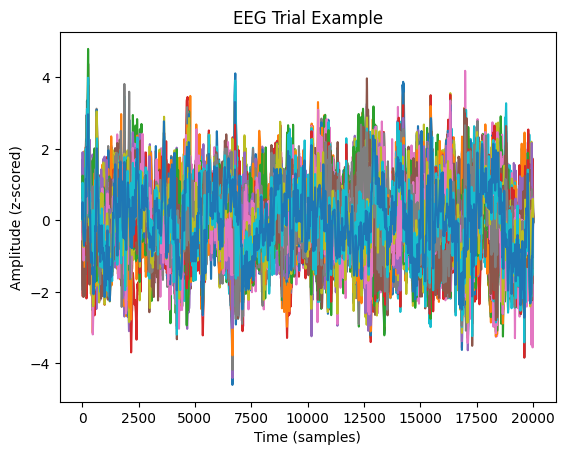

In [13]:
print(all_trials[0]['eeg'].shape)
df_metadata['phoneme'].value_counts()
import matplotlib.pyplot as plt
trial = all_trials[0]['eeg']  # first trial
plt.plot(trial.T)  # transpose to plot time on x-axis
plt.title("EEG Trial Example")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (z-scored)")
plt.show()


one channel is very large 

In [11]:
def remove_noisy_channels(eeg, threshold=10.0):
    """
    Remove EEG channels whose absolute signal exceeds a noise threshold.
    Parameters:
        eeg (ndarray): EEG data (channels x time)
        threshold (float): max absolute value allowed per channel
    Returns:
        Cleaned EEG array with bad channels removed
    """
    max_vals = np.max(np.abs(eeg), axis=1)
    keep_mask = max_vals < threshold
    return eeg[keep_mask, :]
